**Installations and settings**

In [1]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 6.4 MB 8.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
from scipy.special import lambertw
from scipy.stats import kurtosis, norm
from scipy.optimize import fmin
import torch.optim as optim
import scipy.optimize as optims
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from statsmodels.tsa.stattools import acf

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Data preprocessing**

In [3]:
#Getting S&P 500 index from May 2009 - December 2018 as mentioned in the paper
data = yf.download("^GSPC", start='2009-05-01', end='2018-12-31')
df = data['Adj Close']

[*********************100%***********************]  1 of 1 completed


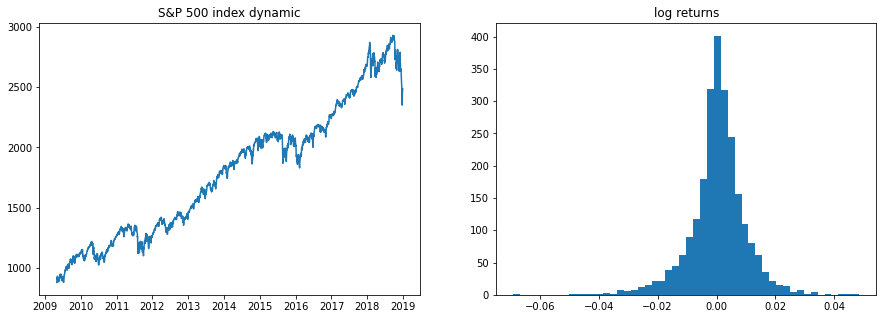

In [4]:
#Calculate the log return series
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
axs[0].plot(df);
axs[0].set_title('S&P 500 index dynamic');
axs[1].hist(log_returns, bins=50);
axs[1].set_title('log returns');

In [5]:
#Normalize -> Inverse Lambert W Transform -> Normalize
#https://github.com/jmnel/neuralsort/blob/master/src/lambertw/gaussianize.py
EPS = np.finfo(float).eps

def w_d(z, delta):
    if delta < EPS:
        return z
    return np.sign(z) * np.sqrt(np.real(lambertw(delta * z**2)) / delta)

def delta_init(z):
    gamma = kurtosis(z, fisher=False, bias=False)
    with np.errstate(all='ignore'):
        delta0 = np.clip(
            1. / 66. * (np.sqrt(66. * gamma - 162.) - 6.), 0.01, 0.48)

    if not np.isfinite(delta0):
        delta0 = 0.01
    return delta0


def delta_gmm(z):
    delta0 = delta_init(z)
    delta0 = np.log(delta0 + 0.001)
    def obj_fn(delta):
        delta = np.exp(delta)
        u = w_d(z, delta)
        if not np.all(np.isfinite(u)):
            return 0.
        gamma_2 = kurtosis(u, fisher=False, bias=False)
        if not np.isfinite(gamma_2) or gamma_2 > 1e10:
            return 1e10
        return abs(gamma_2**2 - 3**2)
    res = optims.minimize(obj_fn,
                         delta0,
                         method='Nelder-Mead')
    return np.exp(res.x[-1])


def igmm(y, tol=1e-6, max_iter=100):
    if np.std(y) < EPS:
        return np.mean(y), np.std(y).clip(EPS), 0.
    delta0 = delta_init(y)
    tau1 = (np.median(y), np.std(y) * (1. - 2. * delta0) ** 0.75, delta0)
    for k in range(max_iter):
        tau0 = tau1
        z = (y - tau1[0]) / tau1[1]
        delta1 = delta_gmm(z)
        assert z is not None
        assert delta1 is not None
        x = tau0[0] + tau1[1] * w_d(z, delta1)
        mu1, sigma1, = np.mean(x), np.std(x)
        tau1 = (mu1, sigma1, delta1)
        if np.linalg.norm(np.array(tau1) - np.array(tau0)) < tol:
            break
        else:
            if k == max_iter - 1:
                pass
    return tau1


def gaussianize(y):
    y = y - np.mean(y)
    tau = igmm(y)
    mu, sigma, delta = tau
    if sigma <= 0 or delta <= 0:
        raise ValueError('sigma or delta non-positive')
    wd = w_d((y - mu) / sigma, delta)
    mx = max(abs(wd))
    wd = wd / mx
    return wd, tau, mx 

scaler_one = StandardScaler();
scaler_one.fit(log_returns);

In [6]:
log_returns_lw, tau, mx = gaussianize(log_returns);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


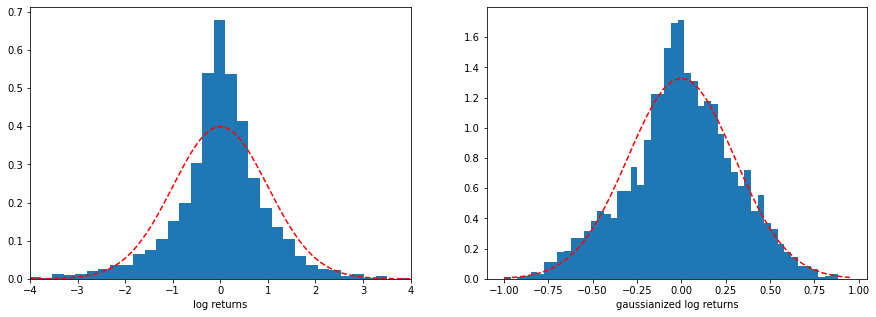

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
axs[0].hist(scaler_one.transform(log_returns), bins=50, density=True);
axs[0].set_xlim([-4, 4]);
x_range = np.linspace(*axs[0].get_xlim(), num=1000);
axs[0].plot(x_range, norm.pdf(x_range), color= 'r', linestyle='dashed');
axs[0].set_xlabel('log returns');

axs[1].hist(log_returns_lw, bins=50, density=True);
x_axis = np.arange(-1, 1, 0.05);
axs[1].plot(x_axis, norm.pdf(x_axis, 0, 0.3), color= 'r', linestyle='dashed');
axs[1].set_xlabel('gaussianized log returns');

**TCN Model training**

In [8]:
#https://github.com/locuslab/TCN/blob/master/TCN/tcn.py
#https://nbviewer.org/github/ICascha/QuantGANs-replication/blob/main/sp500_training.ipynb

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs, kernel_size, dilation, dropout=0.2):
        super(TemporalBlock, self).__init__()
        #self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
        #                                   stride=1, padding='same', dilation=dilation))
        self.conv1 = nn.Conv1d(n_inputs, n_hidden, kernel_size, stride=1, dilation=dilation, padding='same')
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        #self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
        #                                   stride=1, padding='same', dilation=dilation))
        self.conv2 = nn.Conv1d(n_hidden, n_outputs, kernel_size, stride=1, dilation=dilation, padding='same')
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1,
                                 self.conv2, self.relu2, self.dropout2)
        #self.net = nn.Sequential(self.conv1, self.relu1,
        #                         self.conv2, self.relu2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, input_size, output_size, n_hidden=80):
        super(TemporalConvNet, self).__init__()
        layers = []
        for i in range(7):
            num_inputs = input_size if i == 0 else n_hidden
            kernel_size = 2 if i > 0 else 1
            dilation = 2 * dilation if i > 1 else 1
            layers += [TemporalBlock(num_inputs, n_hidden, n_hidden, kernel_size, dilation)]
        self.conv = nn.Conv1d(n_hidden, output_size, 1)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        self.conv.weight.data.normal_(0, 0.01)
    
    def forward(self, x):
        y1 = self.net(x.transpose(1, 2))
        return self.conv(y1).transpose(1, 2)

class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.net = TemporalConvNet(input_size, output_size)

    def forward(self, x):
        return torch.tanh(self.net(x))

class Discriminator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Discriminator, self).__init__()
        self.net = TemporalConvNet(input_size, output_size)

    def forward(self, x):
        return torch.sigmoid(self.net(x))

class TCNDataset(Dataset):    
    def __init__(self, data, length):
        self.data = data
        self.length = length

    def __getitem__(self, index):
        x = np.expand_dims(self.data[index:index+self.length], -1)
        return torch.from_numpy(x).float()

    def __len__(self):
        return len(self.data) - self.length

In [9]:
clip = 0.01
lr = 0.0002
num_epochs = 200
nz = 3
batch_size = 30
seq_len = 127

generator = Generator(nz, 1).to(device)
discriminator = Discriminator(1, 1).to(device)
Doptimizer = optim.RMSprop(discriminator.parameters(), lr=lr)
Goptimizer = optim.RMSprop(generator.parameters(), lr=lr)

dataset = TCNDataset(log_returns_lw.reshape(len(log_returns_lw)), 127)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

t = tqdm(range(num_epochs))
for epoch in t:
    for i, data in enumerate(dataloader, 0):

        discriminator.zero_grad()
        real = data.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        noise = torch.randn(batch_size, seq_len, nz, device=device)
        fake = generator(noise).detach()

        lossD = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
        lossD.backward()
        Doptimizer.step()

        for p in discriminator.parameters():
            p.data.clamp_(-clip, clip)
  
        if i % 5 == 0:
            generator.zero_grad()
            lossG = -torch.mean(discriminator(generator(noise)))
            lossG.backward()
            Goptimizer.step()            

    t.set_description('Loss_D: %.8f Loss_G: %.8f' % (lossD.item(), lossG.item()))

  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:299: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  self.padding, self.dilation, self.groups)
Loss_D: 0.00000229 Loss_G: -0.49993837: 100%|██████████| 200/200 [04:58<00:00,  1.49s/it]


**Samples generation**

In [10]:
#Sample gemeration
def sample_generation():
  def inverse(z, params):
      return params[0] + params[1] * (z * np.exp(z * z * (params[2] * 0.5)))
  noise = torch.randn(1, len(log_returns_lw), 3, device=device)
  sample = generator(noise).detach().cpu().reshape(len(log_returns_lw)).numpy()
  sample_inverse = inverse(sample * mx, tau)
  return sample, sample_inverse

In [11]:
sample, sample_inverse = sample_generation();

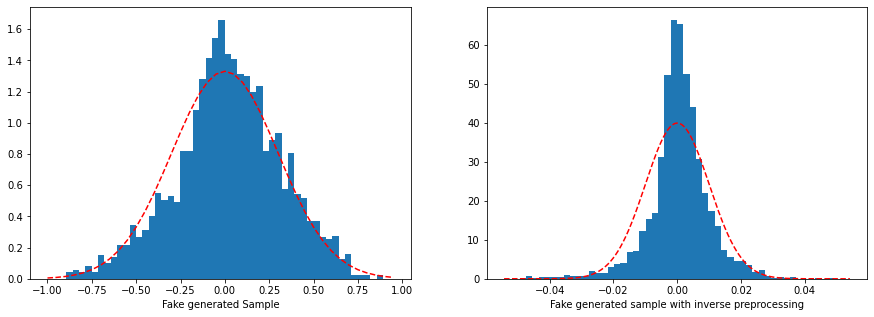

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
axs[0].hist(sample, bins=50, density=True);
x_axis = np.arange(-1, 1, 0.05);
axs[0].plot(x_axis, norm.pdf(x_axis, 0, 0.3), color= 'r', linestyle='dashed');
axs[0].set_xlabel('Fake generated Sample');

axs[1].hist(sample_inverse, bins=50, density=True);
x_range = np.linspace(*axs[1].get_xlim(), num=1000);
axs[1].plot(x_range, norm.pdf(x_range, 0, 0.01), color= 'r', linestyle='dashed');
axs[1].set_xlabel('Fake generated sample with inverse preprocessing');

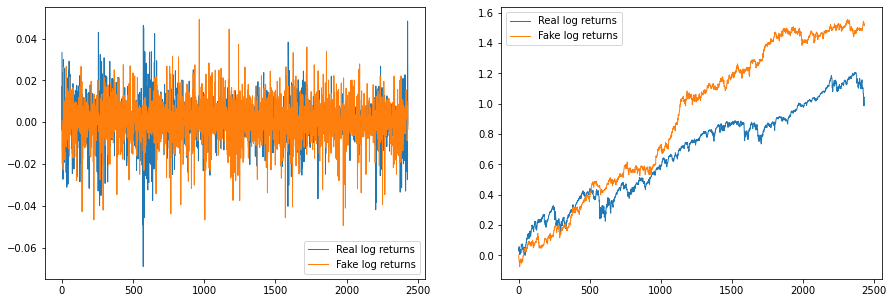

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
axs[0].plot(log_returns, linewidth=1, label = "Real log returns");
axs[0].plot(sample_inverse, linewidth=1, label = "Fake log returns");
axs[0].legend();

axs[1].plot(log_returns.cumsum(), linewidth=1, label = "Real log returns");
axs[1].plot(sample_inverse.cumsum(), linewidth=1, label = "Fake log returns");
axs[1].legend();

In [14]:
data = pd.DataFrame({'Real log return' : log_returns.cumsum(), 'Fake log returns' : sample_inverse.cumsum()})

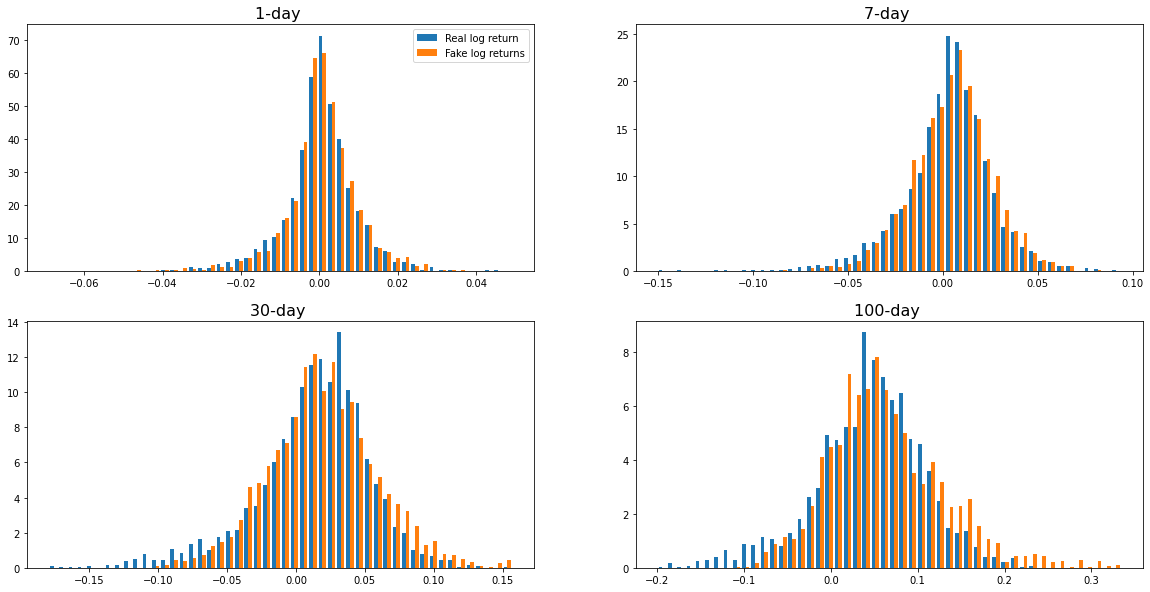

In [15]:
n_bins = 50
windows = [1, 7, 30, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

for i in range(len(windows)):
    d = windows[i]  
    row =  min(max(0, i-1), 1)
    col = i % 2
    axs[row, col].hist((data['Real log return'].diff(d), data['Fake log returns'].diff(d)), bins=50, density=True); 
    axs[row,col].set_title('{}-day '.format(d), size=16)
axs[0,0].legend(['Real log return', 'Fake log returns']);

In [16]:
fake_samples_5 = []
for _ in range(5):
  sample, sample_inverse = sample_generation()
  fake_samples_5.append(sample_inverse)

fake_samples_50 = []
for _ in range(50):
  sample, sample_inverse = sample_generation()
  fake_samples_50.append(sample_inverse)

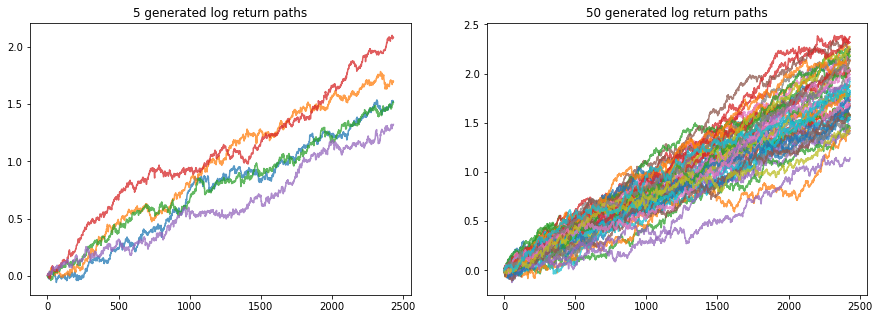

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

axs[0].plot(np.cumsum(fake_samples_5, axis=1).T, alpha=0.75)
axs[0].set_title('5 generated log return paths');

axs[1].plot(np.cumsum(fake_samples_50, axis=1).T, alpha=0.75)
axs[1].set_title('50 generated log return paths');


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


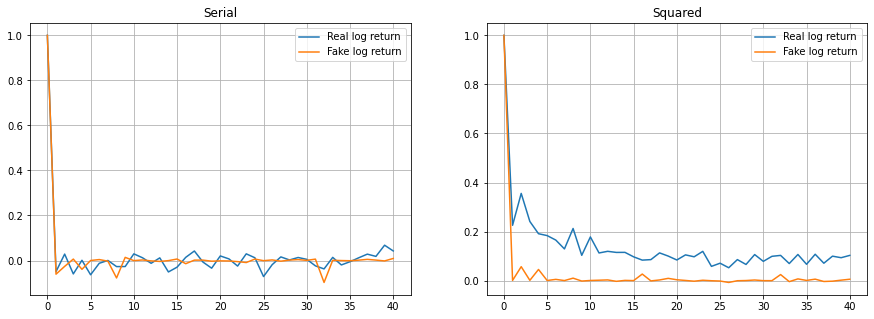

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

axs[0].plot(acf(log_returns, 100), label = 'Real log return');
axs[0].plot(np.mean([acf(x, 100) for x in fake_samples_50], axis = 0), label = 'Fake log return');
axs[0].set_title('Serial');
axs[0].grid(True);
axs[0].legend();

axs[1].plot(acf(log_returns **2, 100), label = 'Real log return');
axs[1].plot( np.mean([acf(x**2, 100) for x in fake_samples_50], axis = 0), label = 'Fake log return');
axs[1].set_title('Squared');
axs[1].grid(True);
axs[1].legend();

**Requeirements for notebook**

In [49]:
!pip freeze > requirements.txt